# 📘 Day 1 — Scaling Laws e Confronto Modelli

**Obiettivo pratico (4 ore di codice)**: Comprendere le scaling laws, analizzare modelli di diverse dimensioni (DistilGPT-2, GPT-2 small, GPT-2 medium), confrontare parametri, memoria, velocità e qualità output.

---

## 🗺️ Roadmap della lezione

| **Sezione** | **Contenuto** | **Tempo stimato** |
|-------------|---------------|-------------------|
| 1 | Setup e utility 
| 2 | Scaling laws: teoria e visualizzazioni 
| 3 | Caricamento modelli (DistilGPT2, GPT2 small, GPT2 medium) 
| 4 | Analisi memoria e parametri 
| 5 | Confronto output su prompt identici 
| 6 | Analisi tempo inferenza e trade-off 
| 7 | Discussione: pre-training vs riuso 

---

## 📚 Parole chiave (per approfondire)

- **Scaling laws (Kaplan et al.)**: relazioni empiriche tra parametri, dati, compute
- **GPT-3**: architettura, dataset, limiti
- **LLaMA**: filosofia open ed efficienza
- **Falcon**: ottimizzazioni specifiche
- **Training distribuito**: data parallelism vs model parallelism
- **Mixed precision training**: FP16, BF16
- **Gradient checkpointing**: trade-off memoria vs compute
- **DeepSpeed e Megatron**: framework per modelli grandi

---

## 1️⃣ Setup e utility (15 minuti)

Prepariamo l'ambiente con le librerie necessarie e utility per monitorare risorse.

In [1]:
# Installazione librerie
%pip install torch transformers matplotlib pandas numpy psutil ipywidgets pandas hf_xet -q

Note: you may need to restart the kernel to use updated packages.


Dopo l'installazione, se appare il messaggio che chiede di riavviare il kernel, dalla toolbar in alto selezionare **"Kernel"** e in seguito **"Restart Kernel and Clear Outputs of All Cells..."** 

**Attendere circa 30 secondi e in seguito NON eseguire nuovamente il blocco "Installazione librerie" ma procedere con il blocco successivo, "Import librerie"**

In [1]:
# Import librerie
import torch
import transformers
from transformers import set_seed, AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_torch_available
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import psutil
import os
from typing import Dict, List
import warnings
import sys
warnings.filterwarnings('ignore')

# Seed per riproducibilità
SEED = 42
set_seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"✅ Trasformers version: {transformers.__version__}")
print(f"✅ Is Torch Available: {is_torch_available()}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"✅ Seed: {SEED}")

✅ Trasformers version: 4.57.1
✅ Is Torch Available: True
✅ PyTorch version: 2.9.0+cpu
✅ Device: CPU
✅ Seed: 42


In [2]:
# Utility per monitorare RAM
def get_memory_usage():
    """
    Restituisce l'uso corrente di memoria RAM in MB.
    
    Returns:
        float: Memoria RAM usata in MB
    """
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Converti in MB

# Test
current_mem = get_memory_usage()
print(f"🧪 Memoria RAM corrente: {current_mem:.2f} MB")

🧪 Memoria RAM corrente: 362.12 MB


In [3]:
# Utility per timing
class Timer:
    """
    Context manager per misurare il tempo di esecuzione.
    
    Uso:
        with Timer("operazione"):
            # codice da misurare
    """
    def __init__(self, name=""):
        self.name = name
        
    def __enter__(self):
        self.start = time.time()
        return self
        
    def __exit__(self, *args):
        self.end = time.time()
        self.elapsed = self.end - self.start
        print(f"⏱️ {self.name}: {self.elapsed:.3f}s")

# Test
with Timer("Test timer"):
    time.sleep(0.1)
    
print("\n✅ Utility caricate")

⏱️ Test timer: 0.101s

✅ Utility caricate


In [4]:
# Creazione directory
os.makedirs('./results_day1', exist_ok=True)
print("✅ Directory ./results_day1 creata")

✅ Directory ./results_day1 creata


---

## 2️⃣ Scaling Laws: teoria e visualizzazioni (45 minuti)

Le **scaling laws** (Kaplan et al., 2020) descrivono relazioni empiriche tra:
- **N**: numero di parametri del modello
- **D**: dimensione del dataset (numero di token)
- **C**: compute (FLOPs, numero di operazioni in virgola mobile, per training)
- **L**: loss (performance del modello)

### Relazioni chiave:

**1. Loss vs Parametri**:
```
L(N) ∝ N^(-α)
```
Dove α ≈ 0.076 (da paper Kaplan et al.)

Questa relazione descrive come la loss di un modello linguistico decresca al crescere del numero di parametri 
𝑁
N. In altre parole, modelli più grandi tendono a ottenere prestazioni migliori (loss più bassa), ma con un miglioramento che segue una legge di potenza decrescente: ogni raddoppio dei parametri porta a un guadagno sempre più marginale. Il valore di α quantifica la rapidità con cui si riducono gli errori all’aumentare della capacità del modello.

**2. Loss vs Dataset Size**:
```
L(D) ∝ D^(-β)
```
Dove β ≈ 0.095

Questa relazione mostra l’impatto della dimensione del dataset di addestramento 
𝐷
D sulla perdita del modello. Aumentare i dati migliora l’apprendimento e riduce la loss, ma anche qui con rendimenti decrescenti: servono quantità sempre maggiori di dati per ottenere miglioramenti marginali. Il valore di β rappresenta quanto “efficientemente” il modello sfrutta nuovi esempi; un β più alto indica una maggiore sensibilità alla quantità di dati disponibili.

**3. Loss vs Compute**:
```
L(C) ∝ C^(-γ)
```
Dove γ ≈ 0.050

Questa curva lega la loss alla quantità complessiva di calcolo 
𝐶
C utilizzata durante l’addestramento (che dipende sia dal numero di parametri che dalla dimensione dei dati). Il parametro γ evidenzia che, pur investendo più potenza computazionale, il miglioramento nella loss cresce lentamente: la riduzione degli errori segue una scala sub-lineare, riflettendo il costo crescente di addestrare modelli sempre più grandi e complessi.

### Implicazioni:
- Aumentare parametri **e** dati insieme è più efficace
- Raddoppiare i parametri riduce la loss di ~5%
- Esiste un trade-off ottimale tra N e D per un dato budget C

### Esempi concreti:
- **GPT-3** (175B parametri): 300B token, ~3.14e23 FLOPs
- **LLaMA-7B**: 1T token (più dati, meno parametri)
- **Falcon-40B**: 1T token, ottimizzazioni architetturali

✅ Grafici scaling laws salvati in ./results_day1/scaling_laws.png


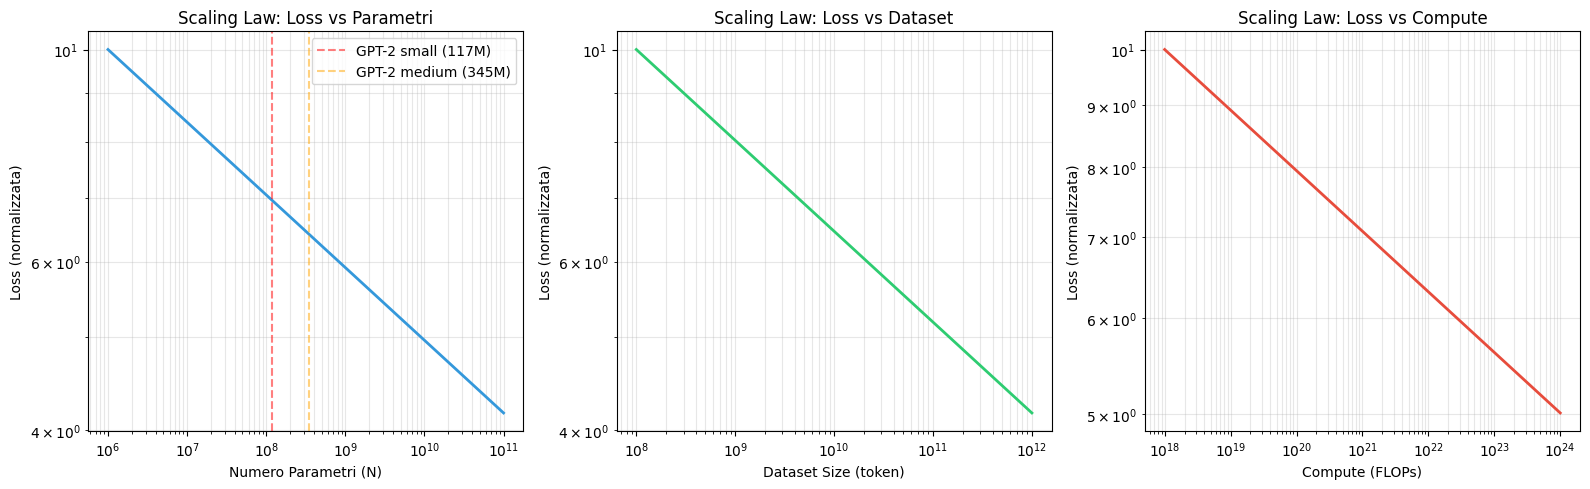

In [5]:
# Visualizzazione scaling laws

# Parametri da paper Kaplan et al.
alpha = 0.076  # Esponente per parametri
beta = 0.095   # Esponente per dataset
gamma = 0.050  # Esponente per compute

# Range di valori (scala logaritmica)
N_range = np.logspace(6, 11, 50)  # 1M a 100B parametri
D_range = np.logspace(8, 12, 50)  # 100M a 1T token
C_range = np.logspace(18, 24, 50) # FLOPs

# Calcola loss (normalizzata)
L_N = N_range ** (-alpha)
L_D = D_range ** (-beta)
L_C = C_range ** (-gamma)

# Normalizza per visualizzazione
L_N = L_N / L_N[0] * 10
L_D = L_D / L_D[0] * 10
L_C = L_C / L_C[0] * 10

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Loss vs Parametri
axes[0].loglog(N_range, L_N, linewidth=2, color='#3498db')
axes[0].set_xlabel('Numero Parametri (N)')
axes[0].set_ylabel('Loss (normalizzata)')
axes[0].set_title('Scaling Law: Loss vs Parametri')
axes[0].grid(True, alpha=0.3, which='both')
axes[0].axvline(117e6, color='red', linestyle='--', alpha=0.5, label='GPT-2 small (117M)')
axes[0].axvline(345e6, color='orange', linestyle='--', alpha=0.5, label='GPT-2 medium (345M)')
axes[0].legend()

# Plot 2: Loss vs Dataset
axes[1].loglog(D_range, L_D, linewidth=2, color='#2ecc71')
axes[1].set_xlabel('Dataset Size (token)')
axes[1].set_ylabel('Loss (normalizzata)')
axes[1].set_title('Scaling Law: Loss vs Dataset')
axes[1].grid(True, alpha=0.3, which='both')

# Plot 3: Loss vs Compute
axes[2].loglog(C_range, L_C, linewidth=2, color='#e74c3c')
axes[2].set_xlabel('Compute (FLOPs)')
axes[2].set_ylabel('Loss (normalizzata)')
axes[2].set_title('Scaling Law: Loss vs Compute')
axes[2].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('./results_day1/scaling_laws.png', dpi=150, bbox_inches='tight')
print("✅ Grafici scaling laws salvati in ./results_day1/scaling_laws.png")
plt.show()

### 🧠 Interpretazione dei grafici delle Scaling Laws

I tre grafici mostrano l’andamento teorico della **loss** in funzione di tre variabili chiave che determinano la qualità e la scalabilità dei modelli linguistici:

1. **Loss vs Numero di Parametri (N)**  
   La curva blu mostra che, all’aumentare dei parametri del modello, la loss diminuisce secondo una legge di potenza.  
   Tuttavia, la pendenza è modesta (α ≈ 0.076): raddoppiare i parametri riduce la loss solo di una piccola frazione.  
   Le linee tratteggiate indicano due configurazioni note di GPT-2 (*small* e *medium*), fornendo un riferimento concreto sulle scale tipiche dei modelli.  

2. **Loss vs Dimensione del Dataset (D)**  
   La curva verde evidenzia come l’aumento del numero di token di addestramento riduca la loss in modo simile.  
   Anche qui si osservano rendimenti decrescenti (β ≈ 0.095): servono dataset sempre più grandi per ottenere miglioramenti marginali.  
   Questo conferma l’importanza di bilanciare quantità e qualità dei dati durante il training.  

3. **Loss vs Compute Totale (C)**  
   La curva rossa mostra la dipendenza della loss dal compute impiegato (misurato in FLOPs).  
   L’esponente γ ≈ 0.050 è il più piccolo dei tre, indicando che incrementare la potenza di calcolo porta benefici ancora più lenti.  
   Ciò riflette il costo crescente di addestrare modelli più grandi e complessi rispetto ai guadagni in accuratezza.  

---

Nel complesso, i grafici illustrano la natura **sub-lineare e a rendimenti decrescenti** delle scaling laws: ogni ordine di grandezza in più di risorse (parametri, dati o calcolo) produce miglioramenti sempre minori nella loss.  
Queste relazioni sono fondamentali per comprendere i limiti pratici della scalabilità dei modelli di linguaggio e per pianificare in modo ottimale l’uso di risorse computazionali e dataset.


### Spiegazione approfondita del codice 

Il codice mostra come visualizzare le scaling laws dei modelli linguistici, cioè le relazioni empiriche tra la loss e tre variabili fondamentali: numero di parametri, dimensione del dataset e potenza di calcolo.

**1) Nelle prime righe vengono importati gli esponenti α, β e γ ricavati dal paper di Kaplan et al. (2020), che descrivono quanto velocemente decresce la loss rispetto a ciascun fattore:**

alpha = 0.076  # Esponente per parametri  
beta = 0.095   # Esponente per dataset  
gamma = 0.050  # Esponente per compute

**2) Successivamente, si definiscono i range di valori su scala logaritmica per ciascuna variabile:**

N_range = np.logspace(6, 11, 50)  # Da 1 milione a 100 miliardi di parametri  
D_range = np.logspace(8, 12, 50)  # Da 100 milioni a 1 trilione di token  
C_range = np.logspace(18, 24, 50) # Da 10¹⁸ a 10²⁴ FLOPs


L’uso di np.logspace consente di coprire ordini di grandezza molto ampi, come tipico nei modelli di deep learning.

**3) Le tre righe successive calcolano la loss teorica in funzione di ciascun fattore, seguendo le leggi di potenza viste in precedenza:**

L_N = N_range ** (-alpha)  
L_D = D_range ** (-beta)  
L_C = C_range ** (-gamma)

**4) Poiché l’obiettivo è una rappresentazione qualitativa, le loss vengono poi normalizzate per renderle confrontabili e graficamente leggibili:**

L_N = L_N / L_N[0] * 10  
L_D = L_D / L_D[0] * 10  
L_C = L_C / L_C[0] * 10

In questo modo tutti i grafici partono da un valore di loss pari a 10 e diminuiscono secondo la legge di scaling.

**5) Si crea quindi una figura con tre sottotrame (subplots) affiancate:**

fig, axes = plt.subplots(1, 3, figsize=(16, 5))


Ognuna di esse rappresenta una delle tre relazioni fondamentali.

Nel primo grafico (Loss vs Parametri), la curva blu mostra come la loss diminuisca all’aumentare del numero di parametri. Le linee verticali tratteggiate in rosso e arancione indicano la posizione approssimativa di GPT-2 small (117M) e GPT-2 medium (345M), fornendo un riferimento concreto.**

Nel secondo grafico (Loss vs Dataset), la curva verde evidenzia l’impatto della dimensione del dataset sui risultati: più dati migliorano la performance, ma con rendimenti decrescenti.

Nel terzo grafico (Loss vs Compute), la curva rossa mostra l’effetto dell’aumento del calcolo (FLOPs) sull’errore: anche qui i miglioramenti si attenuano progressivamente.

**6) Infine, il codice ottimizza la disposizione dei grafici, salva l’immagine nella cartella ./results_day1/ e la visualizza a schermo:**

plt.tight_layout()
plt.savefig('./results_day1/scaling_laws.png', dpi=150, bbox_inches='tight')
plt.show()


**7) La stampa finale conferma l’avvenuto salvataggio:**

print("✅ Grafici scaling laws salvati in ./results_day1/scaling_laws.png")


In sintesi, questo script permette di visualizzare in modo intuitivo come la loss diminuisca secondo leggi di potenza man mano che aumentano i parametri, i dati e la potenza di calcolo, evidenziando la natura scalabile ma con rendimenti decrescenti dei moderni modelli di linguaggio.

In [6]:
# Confronto modelli famosi
models_comparison = {
    'Modello': ['GPT-2 small', 'GPT-2 medium', 'GPT-2 large', 'GPT-3', 'LLaMA-7B', 'LLaMA-13B', 'Falcon-7B', 'Falcon-40B'],
    'Parametri': ['117M', '345M', '762M', '175B', '7B', '13B', '7B', '40B'],
    'Dataset (token)': ['~40B', '~40B', '~40B', '300B', '1T', '1T', '1T', '1T'],
    'Anno': [2019, 2019, 2019, 2020, 2023, 2023, 2023, 2023],
    'Open Source': ['Sì', 'Sì', 'Sì', 'No', 'Sì', 'Sì', 'Sì', 'Sì'],
    'Note': [
        'Baseline, CPU-friendly',
        'Buon trade-off',
        'Richiede GPU',
        'Closed, API only',
        'Efficiente, open',
        'Più potente',
        'Ottimizzato',
        'SOTA open'
    ]
}

df_models = pd.DataFrame(models_comparison)

print("\n📊 Confronto Modelli Famosi:\n")
print(df_models.to_string(index=False))

# Salva
df_models.to_csv('./results_day1/models_comparison.csv', index=False)
print("\n✅ Tabella salvata in ./results_day1/models_comparison.csv")


📊 Confronto Modelli Famosi:

     Modello Parametri Dataset (token)  Anno Open Source                   Note
 GPT-2 small      117M            ~40B  2019          Sì Baseline, CPU-friendly
GPT-2 medium      345M            ~40B  2019          Sì         Buon trade-off
 GPT-2 large      762M            ~40B  2019          Sì           Richiede GPU
       GPT-3      175B            300B  2020          No       Closed, API only
    LLaMA-7B        7B              1T  2023          Sì       Efficiente, open
   LLaMA-13B       13B              1T  2023          Sì            Più potente
   Falcon-7B        7B              1T  2023          Sì            Ottimizzato
  Falcon-40B       40B              1T  2023          Sì              SOTA open

✅ Tabella salvata in ./results_day1/models_comparison.csv


### 💡 Osservazioni chiave:

1. **GPT-3 vs LLaMA**: LLaMA usa molti più dati (1T vs 300B token) con meno parametri → più efficiente
2. **Trend recente**: focus su dataset grandi piuttosto che solo parametri
3. **Open source**: LLaMA e Falcon democratizzano l'accesso a modelli potenti
4. **Trade-off**: GPT-2 small è ancora utile per prototipazione e CPU

### Limiti del pre-training:
- **Allucinazioni**: il modello genera testo plausibile ma falso
- **Dataset rumorosi**: qualità variabile dei dati web
- **Aggiornamento lento**: modelli non conoscono eventi recenti
- **Costi**: training GPT-3 costa ~$4.6M in compute
- **Energia**: impatto ambientale significativo

---

## 3️⃣ Caricamento modelli (30 minuti)

Carichiamo tre modelli della famiglia GPT-2:
- **DistilGPT-2**: 82M parametri (distillato da GPT-2)
- **GPT-2 small**: 117M parametri (originale)
- **GPT-2 medium**: 345M parametri (3x più grande)

Tutti sono **CPU-friendly** e disponibili su Hugging Face.

In [7]:
# Definizione modelli da caricare
MODEL_NAMES = {
    'distilgpt2': 'DistilGPT-2 (82M)',
    'gpt2': 'GPT-2 small (117M)',
    'gpt2-medium': 'GPT-2 medium (345M)'
}

print("📦 Modelli da caricare:")
for key, name in MODEL_NAMES.items():
    print(f"   - {name}")

📦 Modelli da caricare:
   - DistilGPT-2 (82M)
   - GPT-2 small (117M)
   - GPT-2 medium (345M)


In [8]:
# Caricamento modelli e tokenizer
models = {}
tokenizers = {}

print("\n⏳ Caricamento modelli in corso...\n")

for model_key, model_name in MODEL_NAMES.items():
    print(f"Caricamento {model_name}...")
    
    mem_before = get_memory_usage()
    
    with Timer(f"  Tempo caricamento"):
        # Carica tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_key)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        # Carica modello
        model = AutoModelForCausalLM.from_pretrained(model_key)
        model.eval()  # Modalità evaluation
    
    mem_after = get_memory_usage()
    mem_used = mem_after - mem_before
    
    print(f"  Memoria usata: {mem_used:.2f} MB\n")
    
    models[model_key] = model
    tokenizers[model_key] = tokenizer

print("✅ Tutti i modelli caricati!")


⏳ Caricamento modelli in corso...

Caricamento DistilGPT-2 (82M)...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⏱️   Tempo caricamento: 61.527s
  Memoria usata: 70.97 MB

Caricamento GPT-2 small (117M)...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⏱️   Tempo caricamento: 85.017s
  Memoria usata: 79.29 MB

Caricamento GPT-2 medium (345M)...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⏱️   Tempo caricamento: 308.789s
  Memoria usata: 132.38 MB

✅ Tutti i modelli caricati!


---

## 4️⃣ Analisi memoria e parametri (40 minuti)

Analizziamo in dettaglio:
- Numero di parametri totali
- Numero di parametri trainable
- Dimensione del modello su disco
- Memoria RAM richiesta
- Struttura dei layer

In [ ]:
# Funzione per analizzare parametri
def analyze_model_parameters(model, model_name: str) -> Dict:
    """
    Analizza i parametri di un modello.
    
    Args:
        model: modello PyTorch
        model_name: nome del modello
    
    Returns:
        Dizionario con statistiche
    """
    # Conta parametri totali
    total_params = sum(p.numel() for p in model.parameters())
    
    # Conta parametri trainable
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Stima dimensione in MB (assumendo FP32)
    # Ogni parametro FP32 = 4 bytes
    size_mb = (total_params * 4) / (1024 ** 2)
    
    # Conta layer
    num_layers = len(list(model.named_modules()))
    
    return {
        'model': model_name,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'size_mb': size_mb,
        'num_layers': num_layers
    }

# Analizza tutti i modelli
model_stats = []

for model_key, model_name in MODEL_NAMES.items():
    stats = analyze_model_parameters(models[model_key], model_name)
    model_stats.append(stats)

df_stats = pd.DataFrame(model_stats)

print("\n📊 Statistiche Modelli:\n")
print(df_stats.to_string(index=False))

In [ ]:
# Visualizzazione parametri
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Numero parametri
models_names = [m['model'] for m in model_stats]
params_millions = [m['total_params'] / 1e6 for m in model_stats]

axes[0].bar(models_names, params_millions, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Parametri (Milioni)')
axes[0].set_title('Numero di Parametri per Modello')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Aggiungi valori sopra le barre
for i, (name, value) in enumerate(zip(models_names, params_millions)):
    axes[0].text(i, value + 5, f"{value:.1f}M", ha='center', fontsize=11, fontweight='bold')

# Plot 2: Dimensione modello
sizes_mb = [m['size_mb'] for m in model_stats]

axes[1].bar(models_names, sizes_mb, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Dimensione (MB)')
axes[1].set_title('Dimensione Modello (FP32)')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

# Aggiungi valori
for i, (name, value) in enumerate(zip(models_names, sizes_mb)):
    axes[1].text(i, value + 20, f"{value:.0f}MB", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('./results_day1/model_parameters.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafici parametri salvati in ./results_day1/model_parameters.png")
plt.show()

In [ ]:
# Analisi struttura layer (esempio su GPT-2 small)
print("\n🔍 Struttura layer GPT-2 small:\n")

gpt2_model = models['gpt2']

# Conta parametri per tipo di layer
layer_params = {}

for name, param in gpt2_model.named_parameters():
    # Estrai tipo di layer (prima parte del nome)
    layer_type = name.split('.')[0]
    
    if layer_type not in layer_params:
        layer_params[layer_type] = 0
    
    layer_params[layer_type] += param.numel()

# Ordina per numero parametri
layer_params_sorted = sorted(layer_params.items(), key=lambda x: x[1], reverse=True)

print("Parametri per tipo di layer:")
for layer_type, num_params in layer_params_sorted:
    percentage = (num_params / df_stats[df_stats['model'] == 'GPT-2 small (117M)']['total_params'].values[0]) * 100
    print(f"   {layer_type}: {num_params/1e6:.2f}M ({percentage:.1f}%)")

### 💡 Osservazioni:

1. **DistilGPT-2 vs GPT-2**: 30% meno parametri, ma performance simili (distillazione efficace)
2. **GPT-2 medium**: 3x parametri → 3x dimensione → 3x memoria
3. **Scaling lineare**: parametri e dimensione crescono linearmente
4. **Layer transformer**: la maggior parte dei parametri è nei layer attention e feedforward

### Implicazioni pratiche:
- **CPU**: DistilGPT-2 e GPT-2 small sono gestibili
- **GPU**: GPT-2 medium richiede almeno 2GB VRAM
- **Produzione**: considerare quantizzazione per ridurre dimensione

---

## 5️⃣ Confronto output su prompt identici (50 minuti)

Testiamo i tre modelli su prompt identici per confrontare:
- Qualità del testo generato
- Coerenza e fluenza
- Capacità di seguire istruzioni

In [ ]:
# Funzione per generare testo
def generate_text(
    model,
    tokenizer,
    prompt: str,
    max_new_tokens: int = 50,
    temperature: float = 0.7,
    top_p: float = 0.9
) -> str:
    """
    Genera testo dato un prompt.
    
    Args:
        model: modello generativo
        tokenizer: tokenizer
        prompt: prompt di input
        max_new_tokens: numero massimo di token da generare
        temperature: temperatura per sampling (0 = greedy, >1 = più random)
        top_p: nucleus sampling threshold
    
    Returns:
        Testo generato completo (prompt + generazione)
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return generated_text

print("✅ Funzione di generazione definita")

In [ ]:
# Prompt di test
test_prompts = [
    "Artificial intelligence is",
    "The future of technology will",
    "Machine learning models can",
    "In the year 2030, we will",
    "The most important challenge in AI is"
]

print("📝 Prompt di test:")
for i, prompt in enumerate(test_prompts, 1):
    print(f"   {i}. {prompt}")

In [ ]:
# Genera output per tutti i modelli
print("\n⏳ Generazione output in corso...\n")

results = []

for prompt in test_prompts:
    print(f"\n{'='*80}")
    print(f"📝 Prompt: {prompt}")
    print(f"{'='*80}\n")
    
    for model_key, model_name in MODEL_NAMES.items():
        print(f"🤖 {model_name}:")
        
        with Timer("   Tempo generazione"):
            output = generate_text(
                models[model_key],
                tokenizers[model_key],
                prompt,
                max_new_tokens=50,
                temperature=0.7
            )
        
        # Estrai solo la parte generata (rimuovi prompt)
        generated_part = output[len(prompt):].strip()
        
        print(f"   Output: {generated_part}\n")
        
        results.append({
            'prompt': prompt,
            'model': model_name,
            'output': generated_part
        })

print("\n✅ Generazione completata!")

In [ ]:
# Salva risultati
df_results = pd.DataFrame(results)
df_results.to_csv('./results_day1/generation_outputs.csv', index=False)
print("✅ Risultati salvati in ./results_day1/generation_outputs.csv")

### 💡 Analisi qualitativa:

**Cosa osservare negli output**:
1. **Coerenza**: il testo ha senso logico?
2. **Fluenza**: la grammatica è corretta?
3. **Creatività**: il modello genera idee originali o ripete pattern?
4. **Lunghezza**: il modello rispetta il limite di token?

**Differenze attese**:
- **DistilGPT-2**: più semplice, a volte meno coerente
- **GPT-2 small**: buon bilanciamento
- **GPT-2 medium**: più articolato, vocabolario più ricco

**Nota**: tutti e tre i modelli possono generare **allucinazioni** (fatti inventati ma plausibili).

---

## 6️⃣ Analisi tempo inferenza e trade-off (40 minuti)

Misuriamo il tempo di inferenza per valutare il trade-off **qualità vs velocità**.

In [ ]:
# Benchmark inferenza
def benchmark_inference(
    model,
    tokenizer,
    prompt: str,
    num_runs: int = 5
) -> Dict:
    """
    Misura tempo medio di inferenza.
    
    Args:
        model: modello
        tokenizer: tokenizer
        prompt: prompt di test
        num_runs: numero di esecuzioni per media
    
    Returns:
        Dizionario con statistiche
    """
    times = []
    
    for _ in range(num_runs):
        start = time.time()
        _ = generate_text(model, tokenizer, prompt, max_new_tokens=30, temperature=0.7)
        end = time.time()
        times.append(end - start)
    
    return {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times)
    }

print("⏳ Benchmark inferenza in corso...\n")

benchmark_prompt = "Artificial intelligence is"
benchmark_results = []

for model_key, model_name in MODEL_NAMES.items():
    print(f"Benchmark {model_name}...")
    
    stats = benchmark_inference(
        models[model_key],
        tokenizers[model_key],
        benchmark_prompt,
        num_runs=5
    )
    
    benchmark_results.append({
        'model': model_name,
        'mean_time': stats['mean'],
        'std_time': stats['std']
    })
    
    print(f"   Tempo medio: {stats['mean']:.3f}s ± {stats['std']:.3f}s\n")

df_benchmark = pd.DataFrame(benchmark_results)

print("✅ Benchmark completato!")

In [ ]:
# Visualizza trade-off qualità vs velocità
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Tempo inferenza
models_names = df_benchmark['model'].tolist()
mean_times = df_benchmark['mean_time'].tolist()
std_times = df_benchmark['std_time'].tolist()

axes[0].bar(models_names, mean_times, yerr=std_times, color=['#3498db', '#2ecc71', '#e74c3c'], 
            alpha=0.7, edgecolor='black', capsize=5)
axes[0].set_ylabel('Tempo (secondi)')
axes[0].set_title('Tempo Medio di Inferenza')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Plot 2: Trade-off parametri vs velocità
params = [m['total_params'] / 1e6 for m in model_stats]
times = mean_times

axes[1].scatter(params, times, s=200, alpha=0.6, c=['#3498db', '#2ecc71', '#e74c3c'], edgecolors='black', linewidths=2)
axes[1].set_xlabel('Parametri (Milioni)')
axes[1].set_ylabel('Tempo Inferenza (secondi)')
axes[1].set_title('Trade-off: Parametri vs Velocità')
axes[1].grid(True, alpha=0.3)

# Annota punti
for i, name in enumerate(models_names):
    axes[1].annotate(name.split('(')[0].strip(), (params[i], times[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig('./results_day1/inference_benchmark.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafici benchmark salvati in ./results_day1/inference_benchmark.png")
plt.show()

In [ ]:
# Calcola speedup relativo
baseline_time = df_benchmark[df_benchmark['model'] == 'GPT-2 medium (345M)']['mean_time'].values[0]

print("\n📊 Speedup relativo (vs GPT-2 medium):\n")
for idx, row in df_benchmark.iterrows():
    speedup = baseline_time / row['mean_time']
    print(f"   {row['model']}: {speedup:.2f}x")

### 💡 Osservazioni:

1. **Scaling lineare**: tempo di inferenza scala linearmente con i parametri
2. **DistilGPT-2**: ~3x più veloce di GPT-2 medium
3. **Trade-off**: GPT-2 medium è più lento ma genera testo più articolato
4. **CPU**: tutti e tre sono gestibili su CPU per prototipazione

### Quando scegliere quale:
- **DistilGPT-2**: prototipazione rapida, deployment su edge devices
- **GPT-2 small**: buon bilanciamento per la maggior parte dei casi
- **GPT-2 medium**: quando serve qualità massima e velocità non è critica

---

## 7️⃣ Discussione: pre-training vs riuso (20 minuti)

### Quando fare pre-training da zero?

**PRO**:
- Controllo completo su dati e architettura
- Possibilità di ottimizzare per dominio specifico
- Nessuna dipendenza da modelli esterni

**CONTRO**:
- Costi enormi (compute, energia, tempo)
- Richiede dataset giganteschi (centinaia di miliardi di token)
- Expertise tecnico avanzato
- Rischio di risultati peggiori di modelli esistenti

### Quando riusare modelli esistenti?

**PRO**:
- Costi ridotti (solo fine-tuning)
- Risultati rapidi
- Beneficia di anni di ricerca
- Modelli open source disponibili (LLaMA, Falcon, etc.)

**CONTRO**:
- Meno controllo
- Possibili bias ereditati
- Licenze da rispettare

### Alternative moderne:

1. **Fine-tuning**: adatta modello esistente a task specifico
2. **LoRA/QLoRA**: fine-tuning efficiente con pochi parametri
3. **RAG (Retrieval-Augmented Generation)**: combina modello + database
4. **Prompt engineering**: ottimizza prompt senza training
5. **Few-shot learning**: insegna con pochi esempi

### Considerazioni aziendali:

- **Startup**: quasi sempre riuso + fine-tuning
- **Big Tech**: possono permettersi pre-training (Google, Meta, OpenAI)
- **Ricerca**: pre-training per esplorare nuove architetture
- **Produzione**: riuso + ottimizzazioni (quantizzazione, distillazione)

In [ ]:
# Stima costi pre-training (ordine di grandezza)
cost_estimates = {
    'Modello': ['GPT-2 small', 'GPT-2 medium', 'GPT-3', 'LLaMA-7B', 'LLaMA-65B'],
    'Parametri': ['117M', '345M', '175B', '7B', '65B'],
    'Costo Compute (USD)': ['~$50K', '~$200K', '~$4.6M', '~$150K', '~$2.5M'],
    'Tempo (GPU-giorni)': ['~100', '~300', '~10,000', '~500', '~5,000'],
    'CO2 (tonnellate)': ['~5', '~15', '~500', '~25', '~250']
}

df_costs = pd.DataFrame(cost_estimates)

print("\n💰 Stima Costi Pre-training:\n")
print(df_costs.to_string(index=False))

print("\n⚠️ Note:")
print("   - Stime approssimative basate su letteratura pubblica")
print("   - Costi variano con hardware e ottimizzazioni")
print("   - Impatto ambientale significativo")

---

## 🎯 Esercizi TODO

### Esercizio 1: Testa GPT-2 large
Carica GPT-2 large (762M parametri) e confronta con i modelli già testati. È gestibile su CPU?

### Esercizio 2: Analisi vocabolario
Confronta la dimensione del vocabolario dei tre tokenizer. Sono identici?

### Esercizio 3: Batch inference
Misura il tempo di inferenza con batch size diversi (1, 2, 4, 8). Come scala?

### Esercizio 4: Temperature sweep
Genera testo con temperature diverse (0.1, 0.5, 1.0, 1.5) e osserva le differenze.

In [ ]:
# TODO: Esercizio 1 - Testa GPT-2 large
# Scrivi qui il tuo codice

In [ ]:
# TODO: Esercizio 2 - Analisi vocabolario
# Scrivi qui il tuo codice

In [ ]:
# TODO: Esercizio 3 - Batch inference
# Scrivi qui il tuo codice

In [ ]:
# TODO: Esercizio 4 - Temperature sweep
# Scrivi qui il tuo codice

---

## ✅ Soluzioni degli esercizi

In [ ]:
# SOLUZIONE Esercizio 1: Testa GPT-2 large

print("⏳ Caricamento GPT-2 large (774M parametri)...")
print("⚠️  ATTENZIONE: Richiede ~3GB RAM e download ~3GB")

# Decommentare per eseguire (richiede tempo e risorse)
# tokenizer_large = AutoTokenizer.from_pretrained('gpt2-large')
# model_large = AutoModelForCausalLM.from_pretrained('gpt2-large')
# model_large.eval()

# Test generazione
# test_prompt = "The future of artificial intelligence"
# output_large = generate_text(model_large, tokenizer_large, test_prompt, max_new_tokens=50)
# print(f"\nGPT-2 large output:\n{output_large}")

# Analisi parametri
# num_params_large = sum(p.numel() for p in model_large.parameters())
# print(f"\n📊 GPT-2 large: {num_params_large/1e6:.1f}M parametri")

print("\n💡 GPT-2 large ha 774M parametri (2x GPT-2 medium)")
print("   Pro: Migliore qualità output")
print("   Contro: Richiede molta RAM e tempo di inferenza")


In [ ]:
# SOLUZIONE Esercizio 2: Analisi vocabolario

print("📊 Analisi Vocabolario:\n")

for model_key, model_name in MODEL_NAMES.items():
    tokenizer = tokenizers[model_key]
    vocab_size = len(tokenizer)
    
    print(f"{model_name}:")
    print(f"   Vocab size: {vocab_size}")
    print(f"   PAD token: {tokenizer.pad_token}")
    print(f"   EOS token: {tokenizer.eos_token}")
    print(f"   BOS token: {tokenizer.bos_token}\n")

print("💡 Tutti i modelli GPT-2 usano lo stesso tokenizer (BPE con 50257 token)")

In [ ]:
# SOLUZIONE Esercizio 3: Batch inference

batch_prompts = [
    "Machine learning is",
    "Deep learning enables",
    "Natural language processing",
    "Computer vision applications"
]

print("🚀 Batch Inference Test:\n")

# Tokenizza batch
inputs_batch = tokenizers['gpt2'](batch_prompts, return_tensors='pt', padding=True)

# Genera per tutto il batch
start_time = time.time()

with torch.no_grad():
    outputs_batch = models['gpt2'].generate(
        **inputs_batch,
        max_new_tokens=30,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizers['gpt2'].eos_token_id
    )

batch_time = time.time() - start_time

# Decodifica
for i, (prompt, output_ids) in enumerate(zip(batch_prompts, outputs_batch)):
    output_text = tokenizers['gpt2'].decode(output_ids, skip_special_tokens=True)
    print(f"{i+1}. {output_text}\n")

print(f"⏱️ Tempo batch ({len(batch_prompts)} prompts): {batch_time:.2f}s")
print(f"   Tempo medio per prompt: {batch_time/len(batch_prompts):.2f}s")

# Confronto con inferenza sequenziale
start_time = time.time()
for prompt in batch_prompts:
    _ = generate_text(models['gpt2'], tokenizers['gpt2'], prompt, max_new_tokens=30)
sequential_time = time.time() - start_time

print(f"\n📊 Confronto:")
print(f"   Batch: {batch_time:.2f}s")
print(f"   Sequential: {sequential_time:.2f}s")
print(f"   Speedup: {sequential_time/batch_time:.2f}x")

print("\n💡 Batch inference è più efficiente quando si processano molti prompt.")


In [ ]:
# SOLUZIONE Esercizio 4: Temperature sweep

temperatures = [0.1, 0.5, 1.0, 1.5]
test_prompt = "Artificial intelligence is"

print("🌡️ Temperature Sweep:\n")
print(f"Prompt: {test_prompt}\n")

for temp in temperatures:
    print(f"Temperature = {temp}:")
    
    output = generate_text(
        models['gpt2'],
        tokenizers['gpt2'],
        test_prompt,
        max_new_tokens=30,
        temperature=temp
    )
    
    generated = output[len(test_prompt):].strip()
    print(f"   {generated}\n")

print("💡 Osservazioni:")
print("   - Temperature bassa (0.1): output deterministico, ripetitivo")
print("   - Temperature media (0.7-1.0): buon bilanciamento")
print("   - Temperature alta (1.5+): più creativo ma meno coerente")

---

## 🎓 Conclusione Day 1

Oggi abbiamo:
1. ✅ Compreso le **scaling laws** e loro implicazioni
2. ✅ Analizzato esempi concreti: **GPT-3, LLaMA, Falcon**
3. ✅ Caricato e confrontato **3 modelli** di dimensioni diverse
4. ✅ Analizzato **parametri, memoria, velocità**
5. ✅ Confrontato **qualità output** su prompt identici
6. ✅ Discusso **trade-off** e quando riusare vs pre-training

**Prossimi passi (Day 2)**:
- Supervised Fine-Tuning (SFT)
- LoRA e QLoRA per fine-tuning efficiente
- Dataset IMDB per classification
- Confronto base vs fine-tuned

---

## 📁 File generati

```
./results_day1/
├── scaling_laws.png
├── models_comparison.csv
├── model_parameters.png
├── generation_outputs.csv
└── inference_benchmark.png
```